In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, FunctionTransformer, MinMaxScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn_pandas import DataFrameMapper  # If still needed, otherwise remove
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, MDS  # Combined TSNE and MDS
import seaborn as sns
from tslearn.metrics import cdist_dtw
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
## Describe 

## Post Model Analysis
Describe how differences across clusters 

In [ ]:
label_mapping=pd.read_parquet('label_mapping_v5.parquet')
label_mapping['Label'].value_counts(dropna=False)

Label
0    371
3    153
1     81
4     11
2      4
Name: count, dtype: int64

In [ ]:
# Create a metadata dataframe as mapping list for all user,card combinations
df_metadata=pd.DataFrame()
folder_path='dataset'
datetime_col='datetime'
for filename in os.listdir(folder_path):
    if filename.endswith(".parquet"):
        # Read the parquet file
        file_path = os.path.join(folder_path, filename)
        #print(file_path)
        df = pd.read_parquet(file_path)
        df['datetime'] = pd.to_datetime(df[['Year', 'Month', 'Day']].astype(str).agg('-'.join, axis=1) + ' ' + df['Time'])

        for _, group in df.groupby(['User','Card']):
            # Get the latest month for each user-card combination
            latest_month = group[datetime_col].max().to_period('M')
            latest_month_group = group[group[datetime_col].dt.to_period('M') == latest_month]

            df_user=pd.pivot_table(latest_month_group,index=['User','Card'],values=['Amount'],aggfunc=['sum','count'])
            df_user['file_path']=file_path
            df_metadata=pd.concat([df_metadata,df_user])

In [ ]:
df_metadata.to_parquet('df_metadata.parquet')

In [ ]:
label_mapping=pd.read_parquet('label_mapping_v5.parquet')


In [ ]:
df_metadata=pd.read_parquet('df_metadata.parquet')
df_metadata=df_metadata.reset_index()
df_metadata.columns=['User','Card','Sum','Count','file_path']

In [ ]:
df_metadata

,User,Card,Sum,Count,file_path
0,17,2,1503.69,16,dataset\train_batch_0.parquet
1,77,2,1640.50,11,dataset\train_batch_0.parquet
2,151,2,197.45,19,dataset\train_batch_0.parquet
3,176,1,734.75,25,dataset\train_batch_0.parquet
4,211,2,731.42,21,dataset\train_batch_0.parquet
...,...,...,...,...,...
1015,1428,4,818.52,12,dataset\train_batch_9.parquet
1016,1452,0,1066.96,36,dataset\train_batch_9.parquet
1017,1480,0,2563.80,22,dataset\train_batch_9.parquet
1018,1723,3,560.41,17,dataset\train_batch_9.parquet


In [ ]:
df_label_mapping=pd.merge(df_metadata,label_mapping,on=['User','Card'],how='left')

In [ ]:
df_label_mapping

,User,Card,Sum,Count,file_path,Label_Online,Label_Chip,Label_Swipe,Label_Total
0,17,2,1503.69,16,dataset\train_batch_0.parquet,2,3,2,3
1,77,2,1640.50,11,dataset\train_batch_0.parquet,1,3,2,2
2,151,2,197.45,19,dataset\train_batch_0.parquet,0,3,2,1
3,176,1,734.75,25,dataset\train_batch_0.parquet,0,3,2,1
4,211,2,731.42,21,dataset\train_batch_0.parquet,0,3,2,1
...,...,...,...,...,...,...,...,...,...
1015,1428,4,818.52,12,dataset\train_batch_9.parquet,0,3,2,1
1016,1452,0,1066.96,36,dataset\train_batch_9.parquet,0,3,2,1
1017,1480,0,2563.80,22,dataset\train_batch_9.parquet,3,2,0,3
1018,1723,3,560.41,17,dataset\train_batch_9.parquet,0,3,2,1


## Clustering - General 
Initiated 4 clusters based on total daily transaction amount 

In [ ]:

# Step 1: Convert `final_sequences` to DataFrame
df_sequences = pd.DataFrame(final_sequences)  # Each row represents a User-Card's sequence

# Step 2: Create a mapping DataFrame from final_ids
df_users = pd.DataFrame(final_ids, columns=['User', 'Card','Date'])

# Step 3: Merge with df_label_mapping to get the 'Label' column
df_users = df_users.merge(df_label_mapping, on=['User', 'Card'], how='left')

# Step 4: Add Label to df_sequences
df_sequences['Label'] = df_users['Label_Online']

# Step 5: Melt DataFrame for plotting
df_melted = df_sequences.melt(id_vars=['Label'], var_name="Day", value_name="Total Amount")


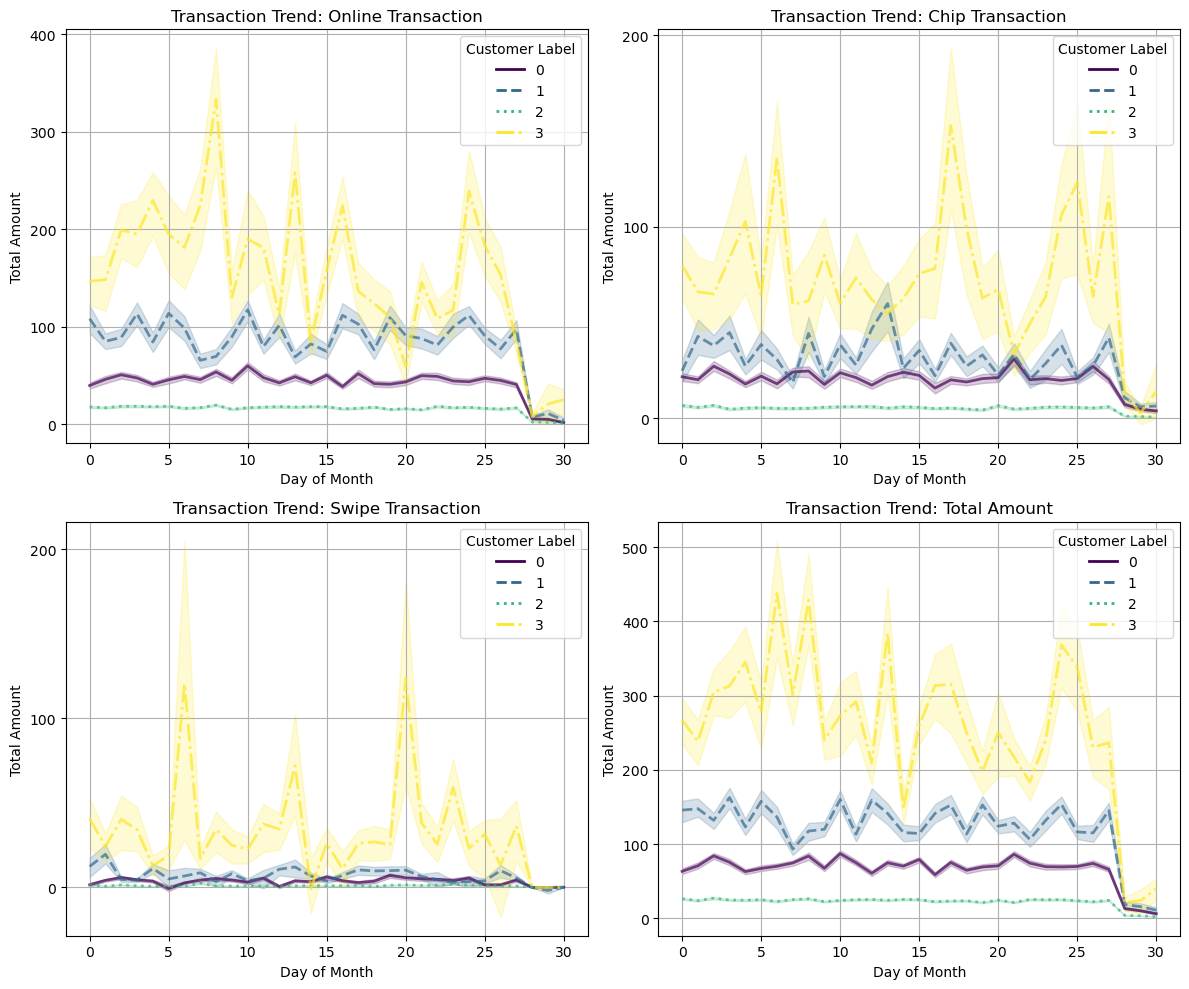

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

# List of transaction types
transaction_types = ['Online Transaction', 'Chip Transaction', 'Swipe Transaction', 'Total Amount']
label=['Label_Online','Label_Chip','Label_Swipe','Label_Total']
# Create a 2x2 subplot grid (adjust the size accordingly)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Define line styles for each label (adjust according to your number of labels)
line_styles = ['-', '--', ':', '-.']  # Solid, dashed, dotted, dash-dot

# Loop through each transaction type
for n, transaction_type in enumerate(transaction_types):
    input_array = []
    for item in final_sequences:
        input_array.append(item[n])

    # Step 1: Convert `final_sequences` to DataFrame
    df_sequences = pd.DataFrame(input_array)  # Each row represents a User-Card's sequence

    # Step 2: Create a mapping DataFrame from final_ids
    df_users = pd.DataFrame(final_ids, columns=['User', 'Card', 'Date'])

    # Step 3: Merge with df_label_mapping to get the 'Label' column
    df_users = df_users.merge(df_label_mapping, on=['User', 'Card'], how='left')

    # Step 4: Add Label to df_sequences
    df_sequences['Label'] = df_users[label[n]]

    # Step 5: Melt DataFrame for plotting
    df_melted = df_sequences.melt(id_vars=['Label'], var_name="Day", value_name="Total Amount")

    # Step 6: Plot trend lines for each label with different line styles
    ax = axs[n]  # Select the current subplot

    # Create the lineplot
    sns.lineplot(data=df_melted, x="Day", y="Total Amount", hue="Label", 
                 estimator='mean',  # Use median for aggregation
                 palette="viridis", alpha=0.7, linewidth=2, ax=ax, ci=50)  # Set line width

    # Get the lines of the plot
    lines = ax.lines

    # Apply different line styles to each label (adjust if there are more than 4 labels)
    for i, line in enumerate(lines):
        line.set_linestyle(line_styles[i % len(line_styles)])  # Cycle through line styles

    # Modify legend to reflect line styles
    handles, labels = ax.get_legend_handles_labels()

    # Recreate legend with updated line styles
    new_handles = []
    for i, handle in enumerate(handles):
        # Create new Line2D objects with the updated line style
        new_handle = Line2D(handle.get_xdata(), handle.get_ydata(), color=handle.get_color(),
                            linestyle=line_styles[i % len(line_styles)], linewidth=2)
        new_handles.append(new_handle)

    # Update the legend with the new handles
    ax.legend(handles=new_handles, labels=labels, title="Customer Label")

    # Add labels and title for each subplot
    ax.set_xlabel("Day of Month")
    ax.set_ylabel("Total Amount")
    ax.set_title(f"Transaction Trend: {transaction_type}")

    # Adjust y-axis ticks to show every 100 instead of 200
    y_min, y_max = ax.get_ylim()  # Get the current y-axis limits
    ax.set_yticks(np.arange(0, y_max, 100))  # Set the y-ticks to have an interval of 100

    # Add gridlines
    ax.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


## Clustering - Split by Transaction Type (Online/Offline...)
Each cluster has specific clusters based on their behavior - More customized on how customer use their card 

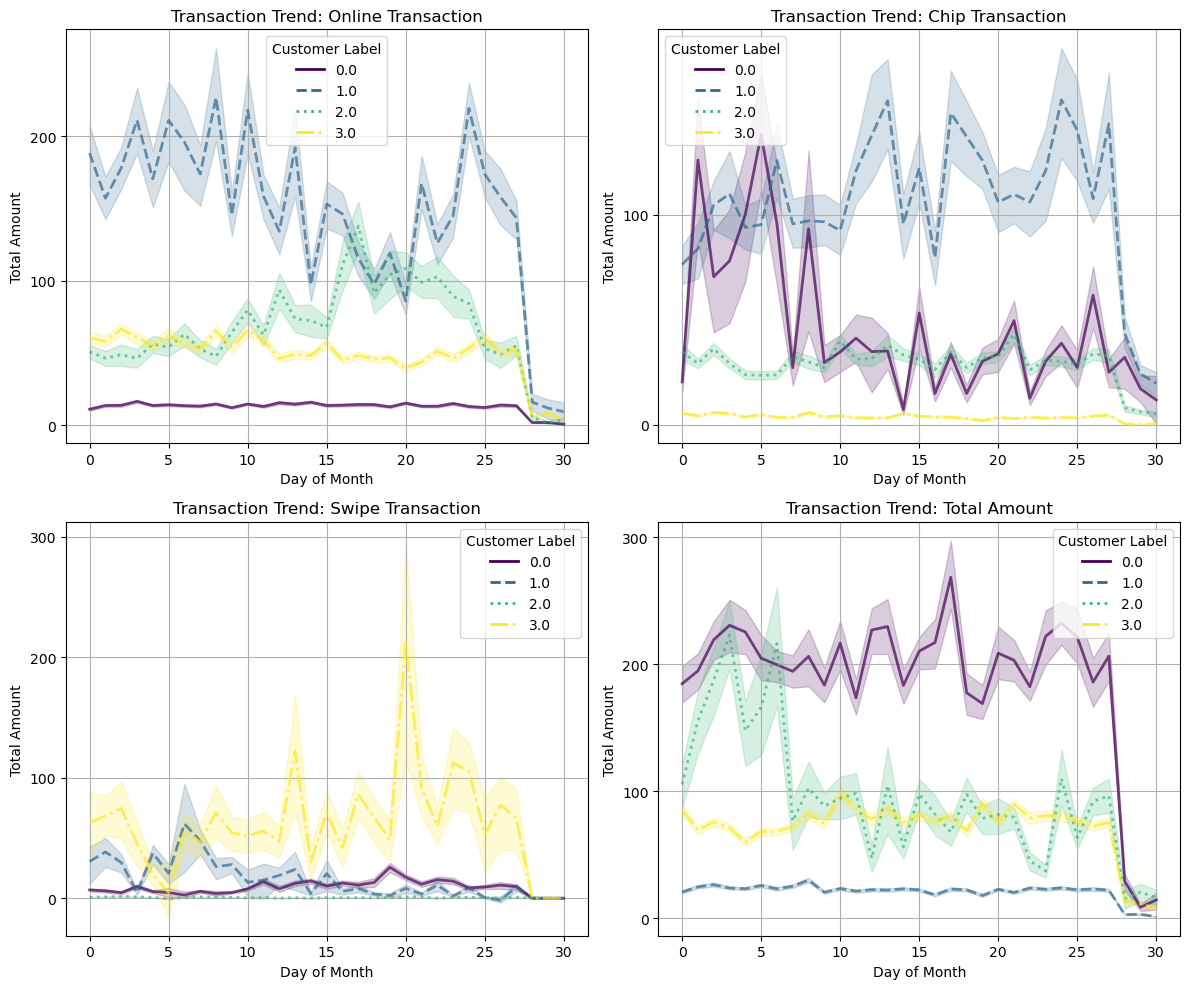

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

# List of transaction types
transaction_types = ['Online Transaction', 'Chip Transaction', 'Swipe Transaction', 'Total Amount']
label=['Label_Online','Label_Chip','Label_Swipe','Label_Total']
# Create a 2x2 subplot grid (adjust the size accordingly)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Flatten the axis array for easier indexing
axs = axs.flatten()

# Define line styles for each label (adjust according to your number of labels)
line_styles = ['-', '--', ':', '-.']  # Solid, dashed, dotted, dash-dot

# Loop through each transaction type
for n, transaction_type in enumerate(transaction_types):
    input_array = []
    for item in final_sequences:
        input_array.append(item[n])

    # Step 1: Convert `final_sequences` to DataFrame
    df_sequences = pd.DataFrame(input_array)  # Each row represents a User-Card's sequence

    # Step 2: Create a mapping DataFrame from final_ids
    df_users = pd.DataFrame(final_ids, columns=['User', 'Card', 'Date'])

    # Step 3: Merge with df_label_mapping to get the 'Label' column
    df_users = df_users.merge(df_label_mapping, on=['User', 'Card'], how='left')

    # Step 4: Add Label to df_sequences
    df_sequences['Label'] = df_users[label[n]]

    # Step 5: Melt DataFrame for plotting
    df_melted = df_sequences.melt(id_vars=['Label'], var_name="Day", value_name="Total Amount")

    # Step 6: Plot trend lines for each label with different line styles
    ax = axs[n]  # Select the current subplot

    # Create the lineplot
    sns.lineplot(data=df_melted, x="Day", y="Total Amount", hue="Label", 
                 estimator='mean',  # Use median for aggregation
                 palette="viridis", alpha=0.7, linewidth=2, ax=ax, ci=50)  # Set line width

    # Get the lines of the plot
    lines = ax.lines

    # Apply different line styles to each label (adjust if there are more than 4 labels)
    for i, line in enumerate(lines):
        line.set_linestyle(line_styles[i % len(line_styles)])  # Cycle through line styles

    # Modify legend to reflect line styles
    handles, labels = ax.get_legend_handles_labels()

    # Recreate legend with updated line styles
    new_handles = []
    for i, handle in enumerate(handles):
        # Create new Line2D objects with the updated line style
        new_handle = Line2D(handle.get_xdata(), handle.get_ydata(), color=handle.get_color(),
                            linestyle=line_styles[i % len(line_styles)], linewidth=2)
        new_handles.append(new_handle)

    # Update the legend with the new handles
    ax.legend(handles=new_handles, labels=labels, title="Customer Label")

    # Add labels and title for each subplot
    ax.set_xlabel("Day of Month")
    ax.set_ylabel("Total Amount")
    ax.set_title(f"Transaction Trend: {transaction_type}")

    # Adjust y-axis ticks to show every 100 instead of 200
    y_min, y_max = ax.get_ylim()  # Get the current y-axis limits
    ax.set_yticks(np.arange(0, y_max, 100))  # Set the y-ticks to have an interval of 100

    # Add gridlines
    ax.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
